# Dataloaders

In [1]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [2]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
# export
from faimed3d.basics import *
from faimed3d.preprocess import *
from faimed3d.augment import *
from faimed3d.widgets.viewer import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ regarding the number of slices and resolution. 

At first, the paths to the data are specified: 

In [4]:
d = pd.read_csv('../data/radiopaedia_cases.csv')
d['label'] = ['Label A', 'Label A', 'Label A', 'Label B', 'Label B']

Raw pixel data for DICOM must sometimes undergo affine transformation (e.g. to be converted to Houndsfiel Units). `PreProcessDicom` is a convenience function which can perform a few frequently needed manipulations with the pixel data. 

In [5]:
# export
class PreprocessDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, rescale=True,
                 correct_spacing=True, spacing = 1,
                 clip_high_values=False, clipping_range=(-2000, 10000)):
        """
        Args:
            rescale (bool): if pixel values should be scaled according to the rescale intercept and slope
            correct_spacing (bool): if spacing of all volumes should be set to a unified value.
            spacing (int): new pixel spacing, default is 1.
            clip_high_values (bool): if abriatry high values shoule be clipped
            clipping_rang (tuple or list): min and maximum to clip values. important when dealing with beam hardening artifacts.
        """

        store_attr()
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        if isinstance(x, TensorMask3D): return x
        if hasattr(x, 'metadata'): # numpy arrays will not have metadata
            if self.rescale: x = x.rescale_pixeldata()
            if self.correct_spacing: x = x.size_correction(self.spacing)
        if self.clip_high_values: x = x.clamp(self.clipping_range[0],
                                              self.clipping_range[1])
        return x.float()

In [6]:
# export 
@patch
def scale_to(t:TensorDicom3D, mean, std):
    mask = t.ne(0) # ne not compatible with __torch_function__ reimplementation
    mean_orig, std_orig = t[mask].mean(), t[mask].std()
    return mean + (t - mean_orig) * (std/std_orig)


class AddChannel(DisplayedTransform):
    "Adds Channels dims, in case they went missing"
    split_idx,order = None, 99
    def __init__(self, p=1.): store_attr()

    def encodes(self, x:Tensor):
        if x.ndim == 3: x = x.unsqueeze(0) # make bs=2 form bs=1 batches
        if x.ndim == 4: x = x.unsqueeze(1)
        return x

In [7]:
# export
def ImageBlock3D(cls=TensorDicom3D, **kwargs):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, batch_tfms=[PreprocessDicom(**kwargs)])

def MaskBlock3D(cls=TensorMask3D, codes=None):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, item_tfms=AddMaskCodes(codes=codes))

## Dataloaders for image classification

In [8]:
# export
class ImageDataLoaders3D(DataLoaders):
    "Nearly identical to fastai `ImageDataLoaders` but adapted for 3D data with some preprocessing steps added"

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"

        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)

        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddChannel()]
        else: batch_tfms = AddChannel()
        if not isinstance(fn_col, list): fn_col = [fn_col]
        
        dblock = DataBlock(blocks=(*[ImageBlock3D(cls=TensorDicom3D) for i in fn_col], y_block),
                           get_x=[ColReader(col, pref=pref, suff=suff) for col in fn_col],
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = len(fn_col))
        return cls.from_dblock(dblock, df, path=path,  **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, rescale_method=None,**kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        
        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddColorChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddColorChannel()]
        else: batch_tfms = AddColorChannel()
        
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_volumetric_files if valid_pct else partial(get_volumetric_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D), CategoryBlock(vocab=vocab)),
                           get_items=get_items,
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        raise NotImplementedError('Currently only from_df and from_csv are supported. '
                                  'You can raise a feature request on Github (https://github.com/kbressem/faimed3d/),'
                                  ' if you need this feature implemented. ')

    @classmethod
    def from_name_func(cls, path, fnames, label_func, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with `label_func`"
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with re expression `pat`"
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)

In [9]:
# export
supported_extensions = {'.dcm', '.nii.gz', '.nii', '.nrrd', '.avi', '.npy'}

def get_volumetric_files(path, recurse=True, folders=None):
    "Get medical volumetric files or video in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=supported_extensions, recurse=recurse, folders=folders)

In [10]:
d

,series,masks,label
0,../data/series/radiopaedia_10_85902_1.nii.gz,../data/masks/radiopaedia_10_85902_1.nii.gz,Label A
1,../data/series/radiopaedia_10_85902_3.nii.gz,../data/masks/radiopaedia_10_85902_3.nii.gz,Label A
2,../data/series/radiopaedia_14_85914_0.nii.gz,../data/masks/radiopaedia_14_85914_0.nii.gz,Label A
3,../data/series/radiopaedia_27_86410_0.nii.gz,../data/masks/radiopaedia_27_86410_0.nii.gz,Label B
4,../data/series/radiopaedia_29_86490_1.nii.gz,../data/masks/radiopaedia_29_86490_1.nii.gz,Label B


In [11]:
dls = ImageDataLoaders3D.from_df(d, 
                                 fn_col = 'series', 
                                 label_col = 'label',
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), 
                                                          resize_to = (20, 150, 150), 
                                                          perc_crop = True),
                                 bs = 2, 
                                 )


/home/feczk001/reine097/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/feczk001/reine097/.local/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [12]:
from fastai.data.core import DataLoaders # for compatibility with show_docs

In [13]:
# export
@patch
def show_batch_3d(dls:DataLoaders, with_mask=False, alpha_mask=0.3, figsize = (4, 4), viewer = 'widget', max_n = 9, **kwargs):
    "Show batch of DataLoader either with simple moasik view or using the DICOM viewer widget"
    
    assert viewer in ['widget', 'mosaik'], 'viewer must be of type `widget` or `mosaik`'
    batch = dls.decode_batch(dls.one_batch(), max_n = max_n)
    xb, yb = list(map(list, zip(*batch)))
    
    if viewer == 'mosaik':
        xb = torch.stack(xb)
        show_images_3d(xb, figsize=figsize, **kwargs)
        if with_mask: 
            yb = torch.stack(yb)
            show_imges_3d(yb, add_to_existing = True, alpha = alpha_mask,
                    cmap = 'jet', figsize=figsize, **kwargs)
        if isinstance(yb, TensorCategory): print(yb)
    if viewer == 'widget':
        xb = [x.squeeze() for x in xb]
        assert xb[0].ndim == 3, 'Currently multiple inputs are not supported'
        if isinstance(yb[0], TensorMask3D): 
            yb = [y.squeeze() for y in yb] if with_mask else None
        elif isinstance(yb[0], MultiCategory): yb = [', '.join(y) for y in yb]
        ListViewer(x=xb, y=yb, figsize=figsize,  max_n = max_n, **kwargs).show()

In [14]:
dls.show_batch_3d()

/panfs/jay/groups/4/miran045/reine097/projects/faimed3d/nbs/faimed3d/basics.py:264: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Removing the first dimension
  warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))


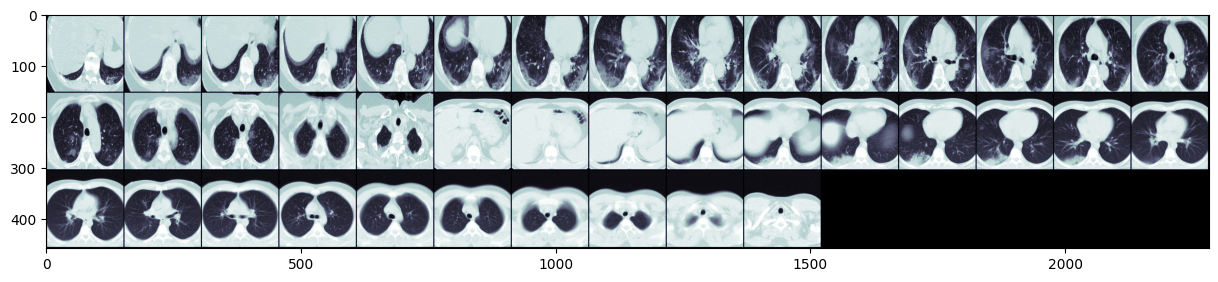

In [15]:
dls.show_batch_3d(viewer='mosaik', nrow = 15, figsize=(15, 15))

In [16]:
from torch import Tensor # for show_docs

In [17]:
# export
@patch
def to_numpy(x:Tensor): return x.detach().cpu().numpy()

@patch
def show_hist(dls:DataLoaders, bins=100, with_stats=False):
    xb, yb = dls.one_batch()

    if with_stats:
        b_min = xb.min().to_numpy()
        b_max = xb.max().to_numpy()
        mean = torch.mean(xb)
        diffs = xb - mean
        var = torch.mean(torch.pow(diffs, 2.0))
        std = torch.pow(var, 0.5)
        zscores = diffs / std
        skews = torch.mean(torch.pow(zscores, 3.0))
        kurt = torch.mean(torch.pow(zscores, 4.0)) - 3.0
        print('batch mean: {}, std: {}'.format(mean.to_numpy(), std.to_numpy()))
        print('px range: {} - {}'.format(b_min, b_max))
        print('skewness: {}, kurtosis:{}'.format(skews.to_numpy(), kurt.to_numpy()))

    plt.hist(xb.detach().cpu().flatten().numpy(), bins = bins)

batch mean: 0.6393925547599792, std: 0.2983616590499878
px range: 0.0 - 1.0
skewness: -0.548978328704834, kurtosis:-1.3938815593719482


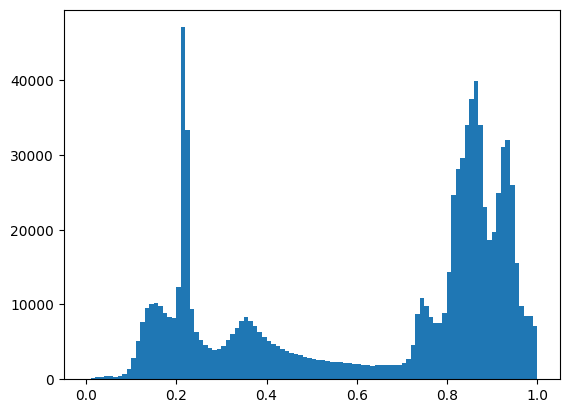

In [18]:
dls.show_hist(with_stats=True)

## Dataloaders for segmentation

In [19]:
#export
class SegmentationDataLoaders3D(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)

    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, codes=None,
                valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, size_for_resampling=None,resample_to_first=False, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"

        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)

        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method
            
        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddChannel()]
        else: batch_tfms = AddChannel()

        if not isinstance(fn_col, list): fn_col = [fn_col]
        if not isinstance(label_col, list): label_col = [label_col]
     
        dblock = DataBlock(blocks=(*[ImageBlock3D(cls=TensorDicom3D) for i in fn_col],
                                   *[MaskBlock3D(codes=codes) for i in label_col]),
                           get_x=[ColReader(col, pref=pref, suff=suff) for col in fn_col],
                           get_y=[ColReader(col, pref=pref, suff=suff) for col in label_col],
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = len(fn_col))

        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

In [20]:
dls = SegmentationDataLoaders3D.from_df(d, 
                                        fn_col='series',
                                        label_col = 'masks',
                                        batch_size = 4)

/home/feczk001/reine097/.local/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [21]:
dls.show_batch_3d(with_mask=True)

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_transforms.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_layers.ipynb.
Converted 06_learner.ipynb.
Converted 06a_models.alexnet.ipynb.
Converted 06b_models.resnet.ipynb.
Converted 06c_model.efficientnet.ipynb.
Converted 06d_models.unet.ipynb.
Converted 06e_models.deeplabv3.ipynb.
Converted 06f_models.losses.ipynb.
Converted 07_callback.ipynb.
Converted 08_widgets.viewer.ipynb.
Converted index.ipynb.
